## Introduction

This is a project to read dial reading from an analog gauge. Dial gauges are used in many industries to monitor various parameters like air/water pressure, temperature, stress/strain etc. Dial gauges are usually analog in nature and monitored manually in industries. Manual monitoring of gauges is tedious and prone to errors. Various approaches based on image processing using opencv and signal processing have been explored in industry. In this demo we explore a CNN based deep learning approach to read gauge dial readings using the images captured from edge devices such as phones/raspberrypi. 

A tensorflow custom estimator is used to train the CNN model on the Google Cloud Platform (GCP) ML Engine.The trained model is also deployed on GCP and employed to get predictions.

## Data Generation, Preprocessing and the Data pipeline

The block diagram below shows a snap of a gauge dial for a particular dial position. The needle and the background for the particular image is seperated using photshop tool. The needle image seperated from the gauge dial is rotated for all the required angles and added to the backgourd to get each candidate image for every label/class corresponding to gauge dial reading. To increase the dataset we augument the images using transformations like scaling, rotation, cropping etc. 

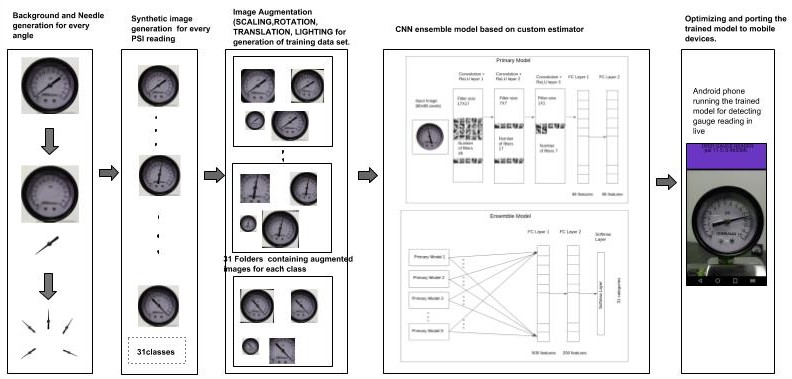

In [2]:
from IPython.display import Image
Image(filename='statics/diagram_1.jpg')

### Training nad Validation Datasets Preparation

The images dataset is first split into train and validation datasets, and then the images size and color mode are adjusted (using keras.preprocessing package). The following code block shows how the train and validation datasets can be obtained via LoadImg module.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from modules.primary_models_modules.train_modules import LoadImg
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


In [4]:
# The color_mode is either 'rgb' or 'grayscale' (default).
X_train, X_validation, y_train, y_validation, cls_indices = LoadImg.Dataset.prep_datasets(
    ver_ratio=0.2, container_path='data/ImageEveryUnit',
    final_img_width=79, final_img_height=79,
    color_mode="grayscale", random_state=1911)


The image pre-processing is complete.


## Data Exploration

### Train and Validation Datasets
There are 1315 images in the training dataset and 329 images in the validation dataset.

In [7]:
print('There are {} images in the train dataset.'.format(X_train.shape[0]))
print('There are {} images in the validation dataset.'.format(X_validation.shape[0]))
print('The images shape is {}'.format(X_train.shape[1:]))

There are 1315 images in the train dataset.
There are 329 images in the validation dataset.
The images shape is (79, 79, 3)


In this example, a width and height of 79 were chosen, so the images shape is (79, 79, 3). In the following code blocks, 12 images are randomly selected from train and validation datasets. 

#### Training Data Samples

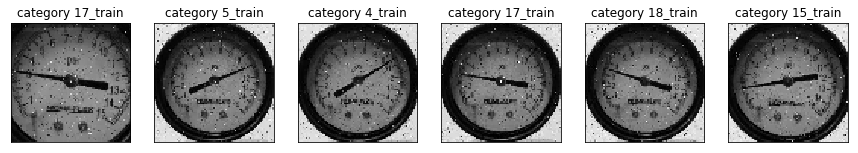

In [10]:
fig = plt.figure(figsize=(15,2.5))
imgs_num = np.random.choice(range(len(X_train)), 6)

for i, img_num in enumerate(imgs_num):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[img_num, :, :, 0], cmap='gray')
    ax.set_title('category {}_train'.format(np.argmax(y_train[img_num])))


#### Validation Data Samples

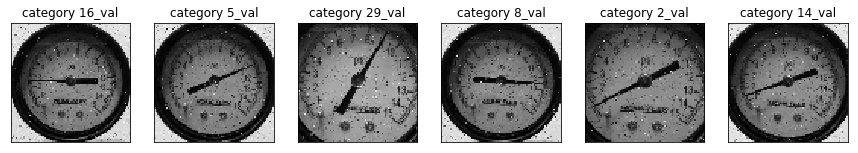

In [11]:
fig = plt.figure(figsize=(15,2.5))
imgs_num = np.random.choice(range(len(X_validation)), 6)

for i, img_num in enumerate(imgs_num):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_validation[img_num, :, :, 0], cmap='gray')
    ax.set_title('category {}_val'.format(np.argmax(y_validation[img_num])))

## Ensembling

The objective of this work is to train multiple models (here, referred to as __primary models__) and eventually use them to construct an ensemble model (a two layer fully connected neural network) which can perform with higher validation accuracy than each individual primary models. To construct the ensemble model, first the primay models are trained and then the probabilities (i.e. the output of the last layer softmax activation functions) of all models are computed and stacked into a numpy array (1D tensor) which will be the input of the ensembling Deep Neural Network (DNN). The ensemble DNN is a classifier that is to predict the same 31 categories. It is trained with the same training dataset and its performance is evaluated versus the same validation dataset as those used for the primary models.

### Primary Models



For each primary model, a Covolutional Neural Network (CNN) architechture is trained and used for predicting the gauge images categories. There are 30 categories that show the pressure level collected by the gauge with half of the pressure unit (here psi) increments and one NaN category (31 categories all together).

The CNN model consists of three CNN and two Fully Connected (FC) layers (the layers are defined in the NewLayers module, CustomEstimator/modules/primary_models_modules/train_modules/NewLayers.py, and the CNN architecture is structured in the NeuralNet module, CustomEstimator/modules/primary_models_modules/train_modules/NeuralNet.py). The activation function of all layers is Rectified Linear Unit (relu) except the last layer which is softmax. The following diagram shows the primary models architecture.

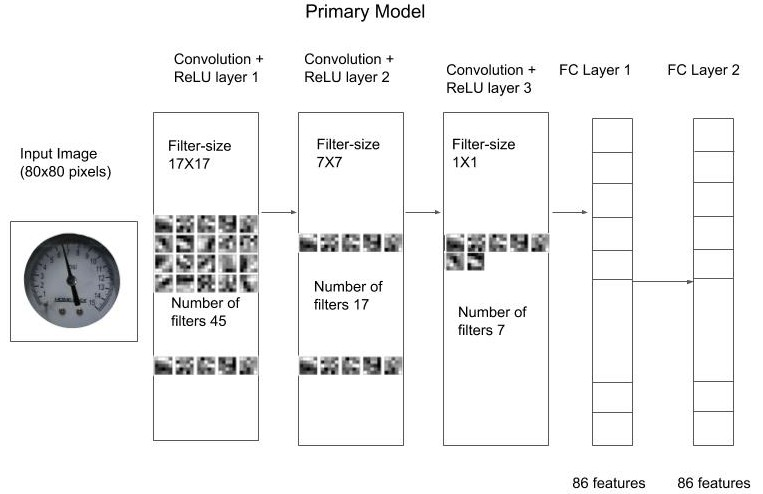

In [12]:
Image(filename='statics/diagram_2.jpg')

For training the primary models, the cross-entropy function and Adam algorithm are employed as the cost function and optimizer, respectively. The model performance is evaluated in each training iteration via the accuracy of the validation dataset and the model checkpoint is saved (in the modules/primary_models_modules/logs/models/main folder) whenever the accuracy is improved.

### Primary Models Training

For the primary models hyperparameter tuning, first a model was trained using images with the same width/height ratio as the original images, which is one here. The hyperparameters of this model were manually tunned and the ones that resulted better performance (i.e. validation dataset accuracy) were used for the subsequent primary models.


In [3]:
from modules.primary_models_modules.train_modules import OptimizeAndLog

##
OptimizeAndLog.OptimizerLogger. \
    train_and_save_logs_three_CNN(filter_size1=17, num_filters1=45, strides_1=[1, 7, 7, 1],
                                  use_pooling_1=True, pooling_ksize_1=[1, 4, 4, 1], pooling_strides_1=[1, 4, 4, 1],
                                  ##
                                  filter_size2=7, num_filters2=17, strides_2=[1, 5, 5, 1],
                                  use_pooling_2=True, pooling_ksize_2=[1, 3, 3, 1], pooling_strides_2=[1, 3, 3, 1],
                                  ##
                                  filter_size3=1, num_filters3=7, strides_3=[1, 1, 1, 1],
                                  use_pooling_3=False, pooling_ksize_3=None, pooling_strides_3=None,
                                  ##
                                  fc_size=86,
                                  num_iterations=1,
                                  learning_rate=2e-4, momentum=None,
                                  X_train=X_train, y_train=y_train,
                                  X_test=X_validation, y_test=y_validation,
                                  models_log_path='./modules/primary_models_modules/logs/models/',
                                  cls_indices=cls_indices,
                                  keep_best_model = True,
                                  padding='SAME',
                                  device_name="/cpu:0")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

epoch 0 ... 
After 0 epochs train_acc is 0.0319 and test_acc is 0.0243

Time usage: 0:00:30


### Feature Engineering

The aspect ratio of the images was changed and for each aspect ratio a model was trained and its saved checkpoint was manually copy-pasted to the modules/primary_models_modules/logs/primary_models for the final ensemble model.

In [5]:
X_train_2, X_validation_2, y_train_2, y_validation_2, _ = LoadImg.Dataset.prep_datasets(
    ver_ratio=0.2, container_path='data/ImageEveryUnit',
    final_img_width=160, final_img_height=80,
    color_mode="grayscale", random_state=1911)

The image pre-processing is complete.


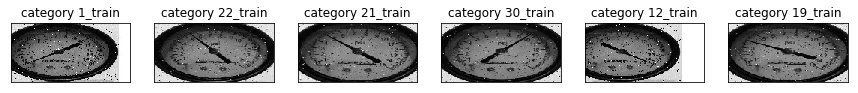

In [6]:
fig = plt.figure(figsize=(15,2.5))
imgs_num = np.random.choice(range(len(X_train_2)), 6)

for i, img_num in enumerate(imgs_num):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train_2[img_num, :, :, 0], cmap='gray')
    ax.set_title('category {}_train'.format(np.argmax(y_train_2[img_num])))

Eight primary models were trained and their checkpoints are used for the ensemble model.

## Ensemble Model

Training the primary models, their checkpoints are used to construct the ensemble model in a tensorflow graph. The following diagram shows the architecture of the ensemble model.

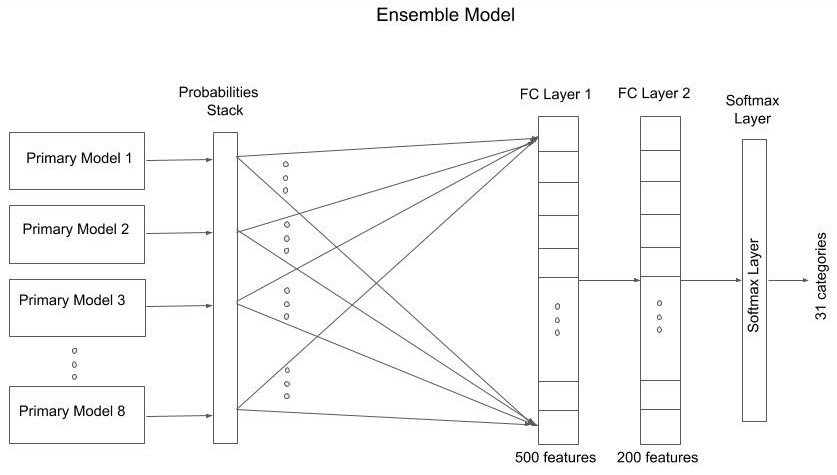

In [6]:
Image(filename='statics/diagram_3.jpg')

In this ensemble model, each primary model outputs the probabilities of 31 categories and the outputs of all the models are stacked up and fed into a two layer Deep Neural Network (DNN).

## Custom Estimator

A custom estimator is used to train the ensemble model on GCP. To train the model, the model graph is first built and saved on a GCP bucket and then imported and used in a python function that is employed as the model_fn of the estimator.

For this custom estimator, a serving input receiver function is used that accepts image(s) converted to base64. The following code block shows the serving input receiver function used here:

In [7]:
def serving_input_receiver_func():
    images_str = tf.placeholder(tf.string, shape=[None], name='export_input_image_bytes')
    def decode_and_resize(image_str_tensor):
        image = tf.image.decode_jpeg(image_str_tensor, channels=3)
        image = tf.expand_dims(image, 0)
        image = tf.image.resize_bilinear(image, [224, 224], align_corners=False)
        image = tf.squeeze(image, squeeze_dims=[0])
        return image
    images = tf.map_fn(decode_and_resize, images_str, dtype=tf.float32)
    return tf.estimator.export.ServingInputReceiver({'img': images}, {'bytes': images_str})

The tf.estimator.train_and_evaluate utility function is used to train, evaluate, and export the model. The trained models are exported to a GCP bucket, which later can be deployed on the GCP ML Engine.

## Hyper-parameters Tunning

The following block shows the contents of the yaml file used for hyper-parameters tunning: 

The yaml file is passed to the config argument when the training job is submitted on GCP, and the learning_rate and batch_size values are optimized through the hyperparamter-tunning job to get the highest validation accuracy.

The best value of 0.933 was achieved for the validation accuracy where the batch_size and learning_rate parameters were respectively 400 and 0.00086.

## Model Deployment

A model with the optimal hyper-parameters was trained and exported to a bucket. The exported model was deployed on the GCP ML Engine to be used for prediction.

To use the deployed model, a GCP cloud function is used where the deployed model is called and the image data, converted to base64, is passed and the prediction results are received.